# Evaluation of machine translation from Flore101

Author: Lujun LI

The flore 101 is a dataset for MT tasks, and it contains more than 101 language pairs.

In this study, this MT tasks are implemented by the following steps:

1. Choose the five different language pairs that have different base spBleu score: 
The following is the spBLEU score benchmark obtained by 'FLORES-101 Evaluation Benchmark for Low-Resource and Multilingual Machine Translation'


| Language Pair         | Abbreviation | spBLEU | Difficulty |
|-----------------------|--------------|--------|------------|
| (English, Maltese)    | mlt          | 49.74  | 40-50      |
| (English, Indonesian) | ind          | 37.26  | 30-40      |
| (English, Std Latvian)| lvs          | 28.79  | 20-30      |
| (English, Icelandic)  | isl          | 18.17  | 10-20      |
| (English, Khmer)      | khm          | 9.82   | 0-10       |


2. Define the prompt for differnet models: Llama2, Llama3 etc.
   For example: 
    The prompt should be like the following in Llama2
   ```python   
      <s>[INST] <<SYS>>
      You are a translation expert, please help me translate the sentence I give to you. Don't answer irrelevant words such as "of course", just reply to me the translated sentence directly.
      <</SYS>>
      Please translate the following English sentence to Maltese.
      "We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.
      [/INST]
   ```
3. Then get the response from models and calculate the spBLEU score base on reference answer and generated answer
4. Finally, do the statistical analysis and causal modeling for future usage.


## Data preprocessing

In [31]:
import pandas as pd
import time
from tqdm import tqdm
import os
import re
import string
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from rouge_score import rouge_scorer
from bert_score import score
from nltk.translate import meteor_score
import matplotlib.pyplot as plt
from openai import OpenAI
from bert_score import BERTScorer
import matplotlib.pyplot as plt

file_name = "exp_result_Llama-2-7b-chat-hf_20240520174033_928097.csv"
foler_path = "data/MT"

output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

In [32]:
def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [33]:
from sacrebleu.metrics import BLEU

bleu = BLEU(tokenize="flores101", effective_order=True)
sys = _data.pure_response.to_list()
refs = _data.sentence_target.to_list()

result = bleu.sentence_score(hypothesis=sys[0], references=[refs[0]]).score


def calculate_sp_bleu(row):
    reference = row["sentence_target"]
    generated_answer = row["pure_response"]
    score = bleu.sentence_score(
        hypothesis=generated_answer, references=[reference]
    ).score
    return score


_data["spbleu"] = _data.apply(calculate_sp_bleu, axis=1)
_data.to_csv(output_path, index=False)

# Draw Figure Together

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "data/MT"
output_photo_name = f"MT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df = df[~df["spbleu"].isna()]

# exam_df = df[
#     [
#         "model_name",
#         "Temperature",
#         "dataset_name" "sentence_eng",
#         "sentence_target",
#         "pure_response",
#         "spbleu",
#     ]
# ]

# exam_df.groupby(["model_name", "Temperature", "dataset_name"]).count()

# import pandas as pd

# quantiles = (
#     exam_df.groupby(["model_name", "Temperature", "dataset_name"])["spbleu"]
#     .quantile(0.1)
#     .reset_index()
# )

# quantiles.columns = ["model_name", "Temperature", "dataset_name", "spbleu_threshold"]
# merged_df = pd.merge(
#     exam_df, quantiles, on=["model_name", "Temperature", "dataset_name"]
# )

# outliers = merged_df[merged_df["spbleu"] <= merged_df["spbleu_threshold"]]

Boxplot for visualization

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


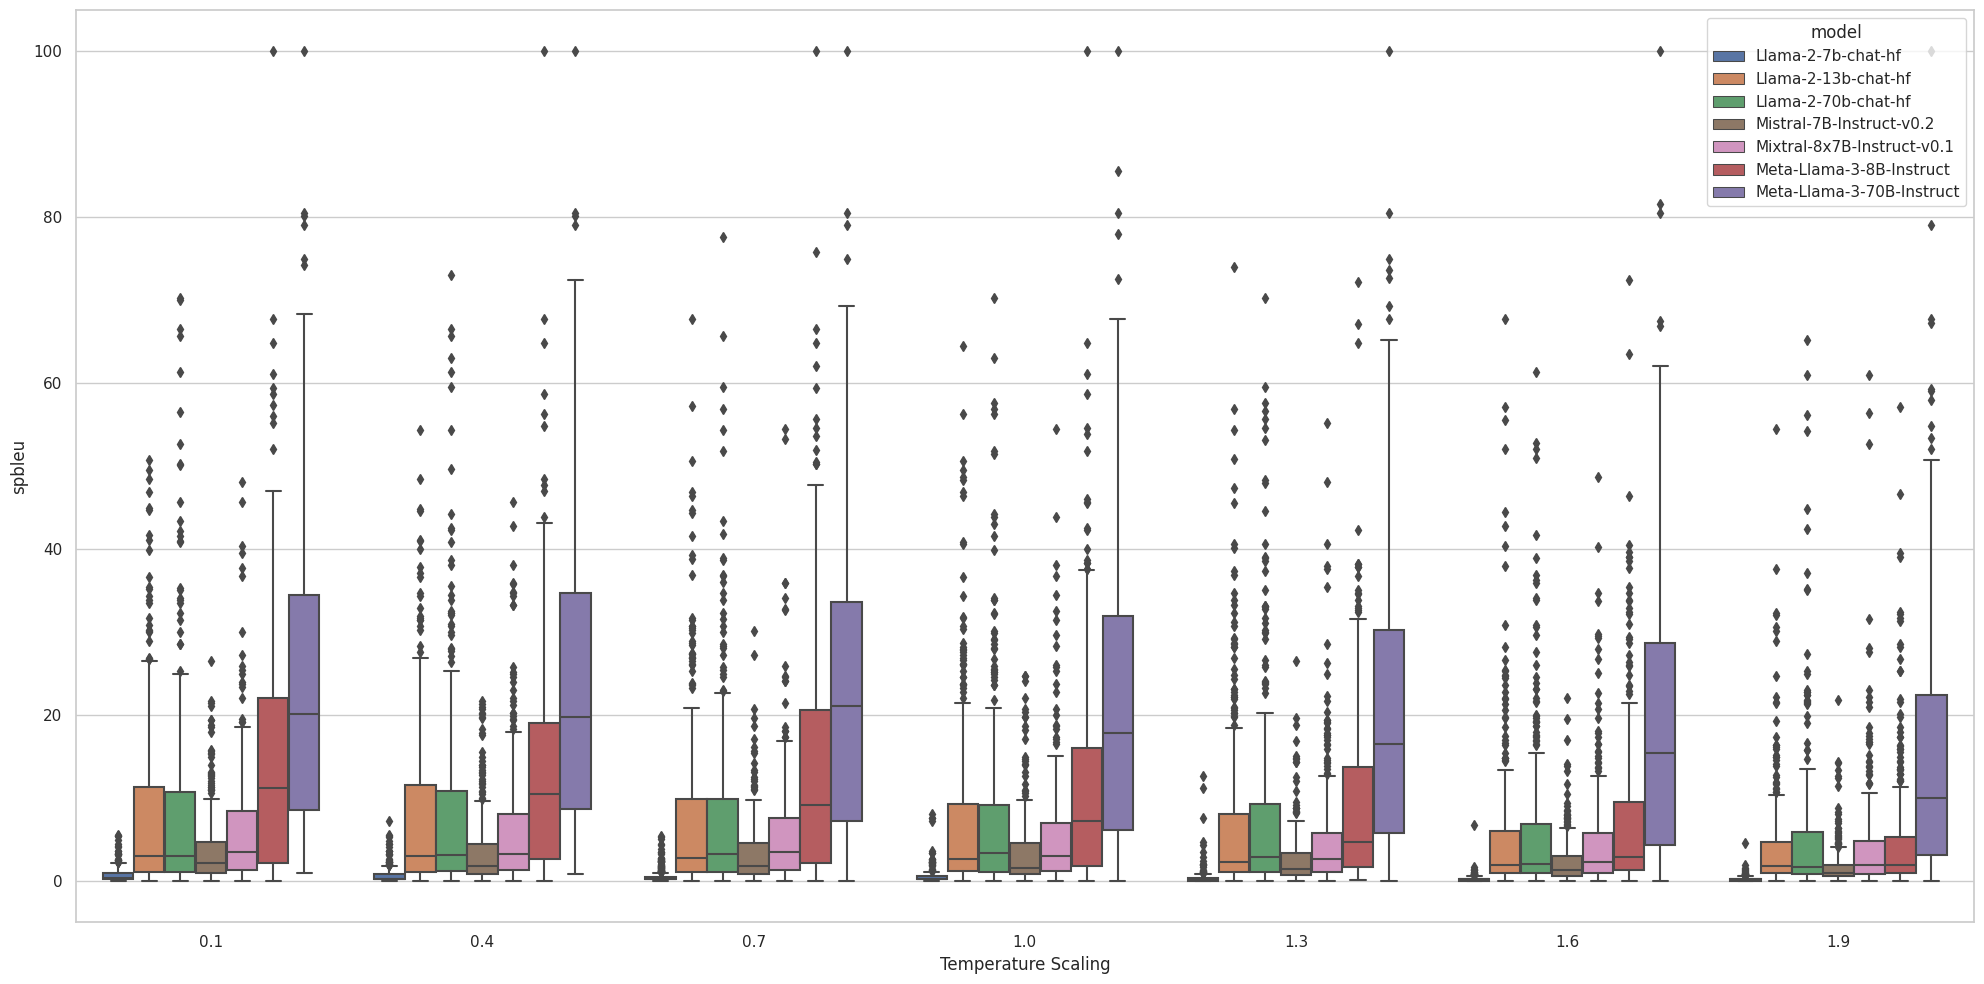

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
}
model_order = list(color_map.keys())
df["Temperature"] = df["Temperature"].round(1)

# Create a single plot
fig, ax = plt.subplots(figsize=(20, 10))

# Boxplot
sns.boxplot(
    x="Temperature",
    y="spbleu",
    hue="model",
    data=df,
    palette=color_map,
    hue_order=model_order,
    ax=ax,
)

# ax.set_title("Boxplot Temperature vs spbleu")
ax.set_xlabel("Temperature Scaling")
ax.set_ylabel("spbleu")
# ax.legend(loc="upper left")

# Adjust layout
plt.tight_layout()
plt.savefig("MT_boxplot.svg", format="svg", bbox_inches="tight")
# Show the plot
plt.show()

Line plot for average score

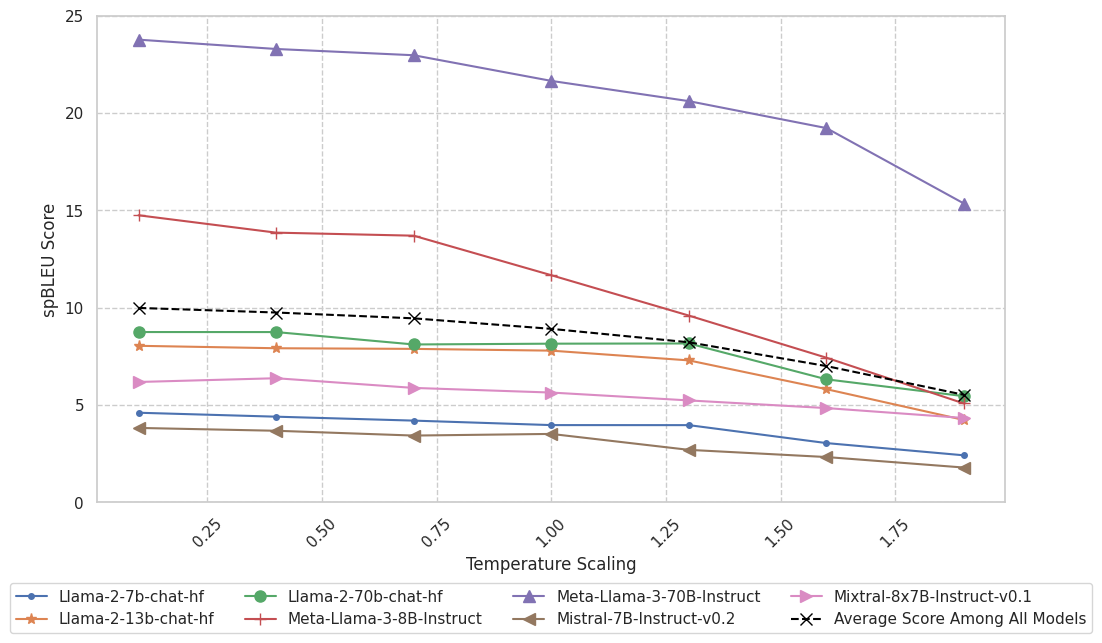

In [37]:
grouped_data = df.groupby(["model", "Temperature"])["spbleu"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["spbleu"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.ylim(0, 25)

plt.xlabel("Temperature Scaling")
plt.ylabel("spBLEU Score")
# plt.title("Machine Translation\nMean spBLEU Score with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

The following bloc is used for the correlation analysis and the max min difference to answer the paper's RQ 1

In [14]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import pandas as pd


metric_name = "spbleu"

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
# Calculate the results for all the models
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    # Normalised Accuracy Value So That The Accuracy Can Be comparable
    accuracy = model_data[metric_name].values
    accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
    # Calculate Correlation Metrics
    corr, p_value = spearmanr(temperatures, accuracy)
    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


# The Calcluation for all the results accross the model
model_data = df
temperatures = model_data["Temperature"].values
accuracy = model_data[metric_name].values
accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
corr, p_value = spearmanr(temperatures, accuracy)
temperatures = sm.add_constant(temperatures)
model = sm.OLS(accuracy, temperatures).fit()
predictions = model.predict(temperatures)
se = np.sqrt(mean_squared_error(accuracy, predictions))
r_squared = model.rsquared
r_squared_adj = model.rsquared_adj
beta_hat = model.params
results.append(
    {
        "model": "All",
        "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
        "r_squared": f"{r_squared:.3f}",
        "r_squared_adj": f"{r_squared_adj:.3f}",
        "Spearman correlation Coefficient": f"{corr:.3f}",
        "P_value": f"{p_value:.3f}",
        "se": f"{se:.3f}",
        "beta_hat_0": f"{beta_hat[0]:.3f}",
        "beta_hat_1": f"{beta_hat[1]:.3f}",
    }
)


grouped_data = df.groupby(["Temperature"])[metric_name].mean().reset_index()

average_performance = grouped_data[metric_name].mean()

standard_deviation = grouped_data[metric_name].std()

range_value = grouped_data[metric_name].max() - grouped_data[metric_name].min()
statistical_range_percentage = (range_value / average_performance) * 100

coefficient_of_variation = (standard_deviation / average_performance) * 100

average_performance, standard_deviation, statistical_range_percentage, coefficient_of_variation

(8.412289833536079, 1.631825295711184, 53.06193261533184, 19.398110716606773)

In [25]:
results_df = pd.DataFrame(results)
results_df

filtered_row = results_df[results_df["model"] == "All"]
spearman_coefficient = float(filtered_row["Spearman correlation Coefficient"].values[0])
p_value = float(filtered_row["P_value"].values[0])

print(f"Average Performance: {average_performance:.3f}")
print(f"Spearman correlation Coefficient: {spearman_coefficient:.3f}")
print(f"p_value: {p_value:.3f}")
# print(f"Standard Deviation: {standard_deviation:.3f}")
print(f"Range Percentage: {statistical_range_percentage:.3f}%")
print(f"Coefficient of Variation: {coefficient_of_variation:.3f}")

Average Performance: 8.412
Spearman correlation Coefficient: -0.135
p_value: 0.000
Range Percentage: 53.062%
Coefficient of Variation: 19.398
